In [21]:
import ctypes
from numpy.ctypeslib import ndpointer
import numpy as np
import scipy.interpolate as inter
import time
import matplotlib.pyplot as plt

In [10]:
# import OXmode from c
# using the following script to compile *.c file
# gcc -shared -o OXmode.so -fPIC OXmode.c -lm

clib = ctypes.cdll.LoadLibrary("./OXmode.so")
cOXmode = clib.OXmode

# cOXmode.restype = None
cOXmode.argtypes = [
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    ctypes.c_double,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"), 
    ctypes.c_int,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"), 
    ctypes.c_int,
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
    ndpointer(ctypes.c_double, flags="C_CONTIGUOUS"),
    ctypes.c_double
                   ]

def OXmode(fps):
    fcO = fps.max()
    fvsO = np.arange(41.0, np.ceil(40*fcO) + 1)/40.0
    vhsO = np.zeros(fvsO.shape)
    
    fe = 4.4/2/np.pi # electron gyro-frequency in MHz
    fcX = (np.sqrt(4*fcO*fcO + fe + fe) + fe)/2.0        # critical frequency in X-mode
    fvsX = np.arange(41.0, np.ceil(40*fcX) + 1)/40.0     # setting the frequencies to skim through
    vhsX = np.zeros(fvsX.shape)
    cOXmode(fps, len(fps), fcO, fcX, dz, fvsO, len(fvsO), fvsX, len(fvsX), vhsO, vhsX, fe)
    return fvsO, vhsO, fvsX, vhsX

In [4]:
N = 17
zmin = 0
zmax = 800
z = np.linspace(zmin,zmax,N)
xvals=np.array([0.,0.22222222,2.4444444,4.33333333,5.6666666,7.22222222,8.88888889,
       10.2222222,9.88888889,8.11111111,6.15,3.5875,0.,0.,0.,0.,0.])
spline = inter.InterpolatedUnivariateSpline(z,xvals)

dz = 0.5
dx = 0.01
Z = np.arange(0,zmax+1,dz)
fps=spline(Z)

In [6]:
# python OXmode
def python_OXmode(fps):
    # O-trace forward model
    fcO=fps.max(0)                          # critical frequency in O-mode
    fvsO=np.arange(41.,np.ceil(40*fcO)+1)/40.     # setting the frequencies to skim through

    vhsO=[] #virtual height array initiated
    for fv in fvsO: # for all ionosonde frequencies
        if fv<fcO+0.025:
            vh=0
            n2b=1
            for fp in fps: # for all heights until reflection height
                X=(fp/fv)**2
                n2t=1-X
                if n2t>0:
                    vh=vh+dz/((np.sqrt(n2b)+np.sqrt(n2t))/2.)
                    n2b=n2t
                else:
                    vh=vh+2.*0.1*np.sqrt(n2b)/(n2b-n2t)
                    break
            vhsO=vhsO+[vh] #virtual height array is built
        else:
            break
    # X-trace forward model
    fe=4.4/2/np.pi # electron gyro-frequency in MHz
    fcX=(np.sqrt(4*fcO*fcO+fe+fe)+fe)/2        # critical frequency in X-mode
    fvsX=np.arange(41.,np.ceil(40*fcX)+1)/40.     # setting the frequencies to skim through

    vhsX=[] #virtual height array initiated
    for fv in fvsX: # for all ionosonde frequencies
        if fv<fcX+0.025:
            vh=0
            n2b=1
            fxb=1
            for fp in fps: # for all heights until reflection height
                X=(fp/fv)**2
                Y=fe/fv
                n2t=1-X*(1-X)/(1-X-Y**2)
                fxt=n2t+X*((1-X)/(1-X-Y**2))**2+(X*Y/(1-X-Y**2))**2
                if n2t>0:
                    vh=vh+dz/((np.sqrt(n2b)/fxb+np.sqrt(n2t)/fxt)/2.)
                    n2b=n2t
                    fxb=fxt
                else:
                    vh=vh+2.*dz*np.sqrt(n2b)/(n2b-n2t)
                    break
            vhsX=vhsX+[vh] #virtual height array is built
        else:
            break
    return fvsO,np.array(vhsO),fvsX,np.array(vhsX)

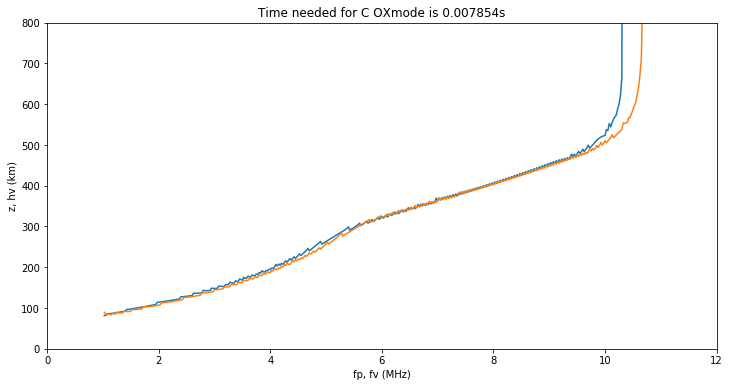

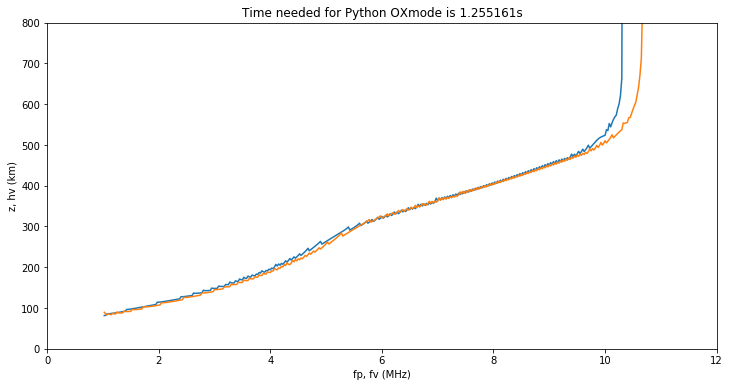

In [26]:
t1 = time.time()
c_fvsO, c_vhsO, c_fvsX, c_vhsX = OXmode(fps)
t2 = time.time()
py_fvsO, py_vhsO, py_fvsX, py_vhsX = python_OXmode(fps)
t3 = time.time()
plt.figure(figsize = (12, 6))
plt.plot(c_fvsO, c_vhsO)
plt.plot(c_fvsX, c_vhsX)
plt.title("Time needed for C OXmode is %fs" %(t2 - t1))
plt.xlim(0,12)
plt.ylim(0,zmax)
plt.xlabel('fp, fv (MHz)')
plt.ylabel('z, hv (km)')
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(py_fvsO, py_vhsO)
plt.plot(py_fvsX, py_vhsX)
plt.title("Time needed for Python OXmode is %fs" %(t3 - t2))
plt.xlim(0,12)
plt.ylim(0,zmax)
plt.xlabel('fp, fv (MHz)')
plt.ylabel('z, hv (km)')
plt.show()

In [ ]:
# TODO: Newest version of OXmode
def OXmode(fps,Z):
    # O-trace forward model
    fcO=fps.max(0)                          # critical frequency in O-mode
    fvsO=np.arange(41.,np.ceil(40*fcO)+1)/40.     # setting the frequencies to skim through

    vhsO=[] #virtual height array initiated
    for fv in fvsO: # for all ionosonde frequencies
        if fv<fcO+0.025:
            vh=0
            n2b=1
            for fp,z in zip(fps,Z): # for all heights until reflection height
                X=(fp/fv)**2
                n2t=1-X
#                if n2t>0:
                if n2t>0:
                    #vh=vh+dz/((np.sqrt(n2b)+np.sqrt(n2t))/2.)
                    prev_dh = dz*((1/np.sqrt(n2b)+1/np.sqrt(n2t))/2.) # keep track of latest dh
                    prevn2b = n2b                                     # keep track of latest nb2
                    vh=vh+prev_dh
                    n2b=n2t
                else:
                    #vh=vh+2.*2*dz*np.sqrt(n2b)/(n2b-n2t)
                    # substract last dh and add last slab made of two slabs:
                    vh=vh - prev_dh + 2.*(2*dz)*np.sqrt(prevn2b)/(prevn2b-n2t) 
                    break
            vhsO=vhsO+[vh] #virtual height array is built
        else:
            break
    # X-trace forward model
    fe0=4.4/2/np.pi # electron gyro-frequency in MHz
    fcX=(np.sqrt(4*fcO*fcO+fe0+fe0)+fe0)/2        # critical frequency in X-mode
    fvsX=np.arange(41.,np.ceil(40*fcX)+1)/40.     # setting the frequencies to skim through

    vhsX=[] #virtual height array initiated
    for fv in fvsX: # for all ionosonde frequencies
        if fv<fcX+0.025:
            vh=0
            n2b=1
            fxb=1
            for fp,z in zip(fps,Z): # for all heights until reflection height
                if z not in cache_fe.keys():
                    r,geoc_lat,lon,aspect,B = jro0.aspect_angle(igrf_year,jro0.xyz0 + jro0.zenith0 * z)
                    fe = const.e * np.linalg.norm(B) * 1e-9 / const.m_e /1e6 /2/np.pi #MHz
                    cache_fe[z] = fe # saving for speed 
                else:
                    fe = cache_fe[z]
                X=(fp/fv)**2
                Y=fe/fv
                n2t=1-X*(1-X)/(1-X-Y**2)
                fxt=n2t+X*((1-X)/(1-X-Y**2))**2+(X*Y/(1-X-Y**2))**2
                if n2t>0:
                    prev_dh = dz/((np.sqrt(n2b)/fxb+np.sqrt(n2t)/fxt)/2.) # keep track of latest dh
                    prevn2b = n2b                                     # keep track of latest nb2
                    vh=vh + prev_dh
                    n2b=n2t
                    fxb=fxt
                else:
                    #vh=vh+2.*dz*np.sqrt(n2b)/(n2b-n2t)*(2-Y)/(1-Y)
                    # substract last dh and add last slab made of two slabs:
                    vh=vh - prev_dh + 2.*(2*dz)*np.sqrt(prevn2b)/(prevn2b-n2t)*(2-Y)/(1-Y)
                    break
            vhsX=vhsX+[vh] #virtual height array is built
        else:
            break
    
    # Faraday phase forward model
    Nefp = fps**2/8.06 * 1e11*(fps>0).astype(np.int_)/corr_factor
    Phase_sim = zeros_like(Nefp)
    for i in range(1,Nefp.shape[0]):
        r,lon,lat,dec,ha,aspect,B = aspect_txty(igrf_year,Z[i],valleytx,valleyty)
        Gyrof = (dot(B,B))**0.5 *1.76e2
        Phase_sim[i] = Phase_sim[i-1] + 80.6/(3e8*5e7**2)*Gyrof*np.abs(cos(aspect))*Nefp[i]*(Z[i]-Z[i-1])*1e3
            
    return fvsO,vhsO,fvsX,vhsX,Phase_sim